In [45]:
#In this section of notebook we will impliment the augmentations code to the CSV files to make 5 columns:
# We need a class, ymin,ymax,xmin,xmax for the locations of the polyLine

In [46]:
# import the libraries
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


In [47]:
#show the paths to where the images annotations is located

images_path = Path('/Volumes/easy store/Sorghum_Images/Images')
anno_path = Path('/Volumes/easy store/Sorghum_Images/Image_Annotations')

In [48]:
print(images_path,"\n",anno_path)

/Volumes/easy store/Sorghum_Images/Images 
 /Volumes/easy store/Sorghum_Images/Image_Annotations


In [49]:
print(os.getcwd())

os.chdir('/Volumes/easy store/Sorghum_Images/Image_Annotations/')
print(os.getcwd())

/Volumes/easy store/Sorghum_Images/Images
/Volumes/easy store/Sorghum_Images/Image_Annotations


In [50]:
# In this section we will develop a dataframe that will parse the CSV file in the image annotations file
# This file is broken up into 5 columns but we only care about 3 of them, One of which needs to be dealt with
# with some regex

anno_file = pd.read_csv('/Volumes/easy store/Sorghum_Images/Image_Annotations/Root_fungi_images_annotations_2.csv')  




In [51]:
anno_file

,filename,file_size,X_shape,Y_shape,labels
0,Snap-209.jpg,1436800,"[0,179,422,672,838,1034,1229,1427,1555,1683,18...","[595,656,678,685,653,614,566,490,426,362,304,2...",cortex
1,Snap-209.jpg,1436800,"[6,131,285,461,646,842,982,1069,1210,1360,1517...","[1315,1354,1370,1389,1395,1376,1344,1299,1238,...",cortex
2,Snap-209.jpg,1436800,"[2336,2384,2554,2557,2342]","[86,269,256,0,80]",cortex
3,Snap-209.jpg,1436800,"[10,122,250,390,518,685,826,957,1094,1203,1293...","[1062,1101,1114,1136,1152,1152,1152,1107,1040,...",stele
4,Snap-211.jpg,1569050,"[10,86,176,281,390,481,504,457,409,333,295,276...","[1266,1209,1161,1113,1061,1018,980,899,828,761...",stele
...,...,...,...,...,...
2699,Snap-374.jpg,3268278,"[259,308,324,317,280,220,124,100,56,14,0,0,44,...","[749,761,723,679,668,625,469,439,439,443,444,5...",arbuscule
2700,Snap-374.jpg,3268278,"[765,751,821,786,787,742,710,675,635,618,621,6...","[1536,1584,1711,1750,1764,1696,1610,1566,1549,...",hypha
2701,Snap-374.jpg,3268278,"[695,766,803,849,903,957,997,1001,1013,905,838...","[567,625,649,605,521,478,385,311,255,185,164,1...",arbuscule
2702,Snap-375.jpg,3704299,"[14,143,345,443,430,465,500,544,593,628,644,61...","[1585,1564,1535,1510,1452,1426,1386,1368,1372,...",hypha


In [52]:
import ast
xmax_list =[]
xmin_list =[]
ymax_list =[]
ymin_list =[]
for line in anno_file["X_shape"]:
    # interpret as a list 
    line = ast.literal_eval(line)
    #print(line)
    if len(line) ==0:
        Xmax = "NA"
        Xmin = "NA"
    else:
        Xmax = max(line)
        Xmin = min(line)
    
    xmax_list.append(Xmax)
    xmin_list.append(Xmin)

for line in anno_file["Y_shape"]:
    # interpret as a list 
    line = ast.literal_eval(line)
    #print(line)
    if len(line) ==0:
        Ymax = "NA"
        Ymin = "NA"
    else:
        Ymax = max(line)
        Ymin = min(line)
    
    ymax_list.append(Ymax)
    ymin_list.append(Ymin)
    
# assign the values in the list to rows in the dataframe, return the dataframe

anno_file["x_max"] = xmax_list
anno_file["x_min"] = xmin_list
anno_file["y_max"] = ymax_list
anno_file["y_min"] = ymin_list
df = anno_file.dropna()



In [53]:
df

,filename,file_size,X_shape,Y_shape,labels,x_max,x_min,y_max,y_min
0,Snap-209.jpg,1436800,"[0,179,422,672,838,1034,1229,1427,1555,1683,18...","[595,656,678,685,653,614,566,490,426,362,304,2...",cortex,2131,0,1142,0
1,Snap-209.jpg,1436800,"[6,131,285,461,646,842,982,1069,1210,1360,1517...","[1315,1354,1370,1389,1395,1376,1344,1299,1238,...",cortex,2554,3,1638,531
2,Snap-209.jpg,1436800,"[2336,2384,2554,2557,2342]","[86,269,256,0,80]",cortex,2557,2336,269,0
3,Snap-209.jpg,1436800,"[10,122,250,390,518,685,826,957,1094,1203,1293...","[1062,1101,1114,1136,1152,1152,1152,1107,1040,...",stele,2554,10,1386,0
4,Snap-211.jpg,1569050,"[10,86,176,281,390,481,504,457,409,333,295,276...","[1266,1209,1161,1113,1061,1018,980,899,828,761...",stele,2560,5,1618,419
...,...,...,...,...,...,...,...,...,...
2698,Snap-389.jpg,3550638,"[1482,1556,1585,1571,1529,1522,1515,1503,1456,...","[779,833,905,1011,1076,1146,1213,1256,1262,125...",hypha,1706,1304,1326,558
2699,Snap-374.jpg,3268278,"[259,308,324,317,280,220,124,100,56,14,0,0,44,...","[749,761,723,679,668,625,469,439,439,443,444,5...",arbuscule,324,0,761,439
2700,Snap-374.jpg,3268278,"[765,751,821,786,787,742,710,675,635,618,621,6...","[1536,1584,1711,1750,1764,1696,1610,1566,1549,...",hypha,996,618,1918,1536
2701,Snap-374.jpg,3268278,"[695,766,803,849,903,957,997,1001,1013,905,838...","[567,625,649,605,521,478,385,311,255,185,164,1...",arbuscule,1013,646,649,164


In [54]:
df.labels.unique()

array(['cortex', 'stele', 'hypha', 'coil', 'arbuscule', 'non-amf(fungus)'],
      dtype=object)

In [55]:
class_dict = {'hypha': 0, 'coil': 1, 'arbuscule': 2, 'non-amf(fungus)': 3,'cortex': 4,'stele': 5}
df['labels'] = df['labels'].apply(lambda x:  class_dict[x])
df= df.drop(columns=['X_shape', 'Y_shape'])

<ipython-input-55-665939759c0b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels'] = df['labels'].apply(lambda x:  class_dict[x])


In [56]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

Image Dimension    :  (1920, 2560, 3)
Image Height       :  1920
Image Width        :  2560
Number of Channels :  3


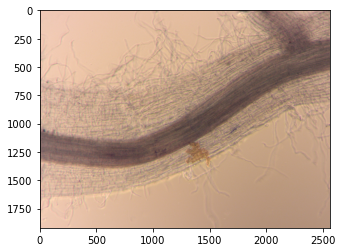

In [57]:
os.chdir("/Volumes/easy store/Sorghum_Images/Images")
import cv2
import matplotlib.pyplot as plt
img = read_image('Snap-209.jpg')

plt.imshow(img)

 
# get dimensions of image
dimensions = img.shape
 
# height, width, number of channels in image
height = img.shape[0]
width = img.shape[1]
channels = img.shape[2]
 
print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)


In [58]:
# okay so we still need to get the dimensions from the data set and we need to make 
# sure we add that to our annotations file, this takes a while, go get food

width_list = []
height_list =[]
for image in df["filename"]:
    img = read_image(str(image))
    dimensions = img.shape
    height = img.shape[0]
    width = img.shape[1]
    height_list.append(height)
    width_list.append(width)

df['width'] = width_list
df['height'] = height_list
    
    


In [59]:
df= df.drop(columns=['file_size'])
df

,filename,labels,x_max,x_min,y_max,y_min,width,height
0,Snap-209.jpg,4,2131,0,1142,0,2560,1920
1,Snap-209.jpg,4,2554,3,1638,531,2560,1920
2,Snap-209.jpg,4,2557,2336,269,0,2560,1920
3,Snap-209.jpg,5,2554,10,1386,0,2560,1920
4,Snap-211.jpg,5,2560,5,1618,419,2560,1920
...,...,...,...,...,...,...,...,...
2698,Snap-389.jpg,0,1706,1304,1326,558,2560,1920
2699,Snap-374.jpg,2,324,0,761,439,2560,1920
2700,Snap-374.jpg,0,996,618,1918,1536,2560,1920
2701,Snap-374.jpg,2,1013,646,649,164,2560,1920


In [60]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

In [61]:
def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


In [62]:
df = df[['filename','width','height','labels','x_min','y_min','x_max','y_max']]

In [63]:
df

,filename,width,height,labels,x_min,y_min,x_max,y_max
0,Snap-209.jpg,2560,1920,4,0,0,2131,1142
1,Snap-209.jpg,2560,1920,4,3,531,2554,1638
2,Snap-209.jpg,2560,1920,4,2336,0,2557,269
3,Snap-209.jpg,2560,1920,5,10,0,2554,1386
4,Snap-211.jpg,2560,1920,5,5,419,2560,1618
...,...,...,...,...,...,...,...,...
2698,Snap-389.jpg,2560,1920,0,1304,558,1706,1326
2699,Snap-374.jpg,2560,1920,2,0,439,324,761
2700,Snap-374.jpg,2560,1920,0,618,1536,996,1918
2701,Snap-374.jpg,2560,1920,2,646,164,1013,649


In [64]:
def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [65]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path[0::])
    #cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [66]:
#Populating Training DF with new paths and bounding boxes, this takes a while
new_paths = []
new_bbs = []
write_path = Path('/Volumes/easy store/Sorghum_Images/Images/images_resized/')
for index, row in df.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], write_path, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df['new_path'] = new_paths
df['new_bb'] = new_bbs

<ipython-input-66-8c7a34e132d0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_path'] = new_paths
<ipython-input-66-8c7a34e132d0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_bb'] = new_bbs


In [68]:
im = cv2.imread(str(df.values[58][0]))
bb = create_bb_array(df.values[58])
print(im.shape)

(1920, 2560, 3)


In [69]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([161.,   6., 482., 347.], dtype=float32)

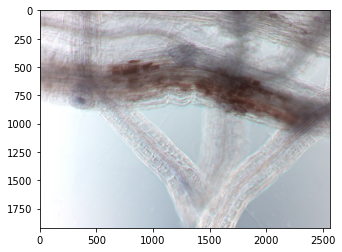

In [70]:
plt.imshow(im)

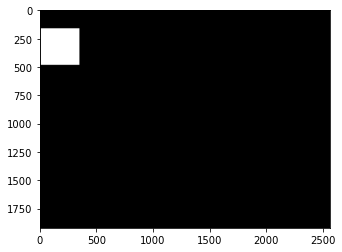

In [71]:
plt.imshow(Y, cmap='gray')

In [72]:
df

,filename,width,height,labels,x_min,y_min,x_max,y_max,new_path,new_bb
0,Snap-209.jpg,2560,1920,4,0,0,2131,1142,/Volumes/easy store/Sorghum_Images/Images/imag...,"[0.0, 0.0, 178.0, 371.0]"
1,Snap-209.jpg,2560,1920,4,3,531,2554,1638,/Volumes/easy store/Sorghum_Images/Images/imag...,"[83.0, 0.0, 255.0, 445.0]"
2,Snap-209.jpg,2560,1920,4,2336,0,2557,269,/Volumes/easy store/Sorghum_Images/Images/imag...,"[0.0, 408.0, 41.0, 446.0]"
3,Snap-209.jpg,2560,1920,5,10,0,2554,1386,/Volumes/easy store/Sorghum_Images/Images/imag...,"[0.0, 2.0, 216.0, 445.0]"
4,Snap-211.jpg,2560,1920,5,5,419,2560,1618,/Volumes/easy store/Sorghum_Images/Images/imag...,"[65.0, 1.0, 252.0, 446.0]"
...,...,...,...,...,...,...,...,...,...,...
2698,Snap-389.jpg,2560,1920,0,1304,558,1706,1326,/Volumes/easy store/Sorghum_Images/Images/imag...,"[87.0, 228.0, 206.0, 297.0]"
2699,Snap-374.jpg,2560,1920,2,0,439,324,761,/Volumes/easy store/Sorghum_Images/Images/imag...,"[69.0, 0.0, 118.0, 56.0]"
2700,Snap-374.jpg,2560,1920,0,618,1536,996,1918,/Volumes/easy store/Sorghum_Images/Images/imag...,"[240.0, 108.0, 299.0, 173.0]"
2701,Snap-374.jpg,2560,1920,2,646,164,1013,649,/Volumes/easy store/Sorghum_Images/Images/imag...,"[26.0, 113.0, 100.0, 176.0]"


In [76]:
# all kinds of pytorch transformations if we need them
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

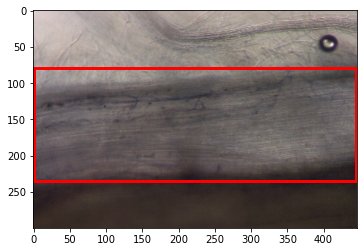

In [77]:
#original
im = cv2.imread(str(df.values[68][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df.values[68][9])

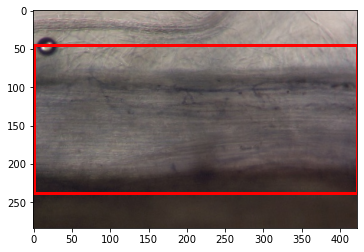

In [79]:

im, bb = transformsXY(str(df.values[68][8]),df.values[68][9],True )
show_corner_bb(im, bb)

In [80]:
df = df.reset_index()

In [81]:
type(df["new_path"][1])

str

In [82]:
train_df=df[:500] 

In [101]:
train_df['labels']

0      4
1      4
2      4
3      5
4      5
      ..
495    4
496    5
497    5
498    4
499    4
Name: labels, Length: 500, dtype: int64

In [83]:
X = train_df[['new_path', 'new_bb']]
Y = train_df['labels']

In [84]:
X["new_path"][1]

'/Volumes/easy store/Sorghum_Images/Images/images_resized/Snap-209.jpg'

In [85]:
os.chdir('/Volumes/easy store/Sorghum_Images/Images/images_resized/')

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=11)

In [87]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [88]:
class RootDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [89]:
train_ds = RootDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RootDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [90]:
valid_ds

In [91]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [92]:
next(iter(train_dl))

[tensor([[[[ 0.0169, -0.1187,  0.0213,  ...,  1.3841,  1.3731,  1.3049],
           [ 0.2940,  0.4048,  0.3290,  ...,  1.3892,  1.3045,  1.2273],
           [ 0.2988,  0.5972,  0.5270,  ...,  1.1989,  1.1048,  1.1872],
           ...,
           [ 0.4463,  0.5625,  0.7962,  ...,  1.3493,  1.3085,  1.3370],
           [ 0.3123,  0.4385,  0.7629,  ...,  1.3639,  1.3194,  1.3397],
           [ 0.2202,  0.3982,  0.5363,  ...,  1.3641,  1.3306,  1.3408]],
 
          [[-0.0349, -0.1696,  0.0073,  ...,  1.2589,  1.2602,  1.1905],
           [ 0.2785,  0.4259,  0.3459,  ...,  1.2151,  1.1655,  1.0866],
           [ 0.3272,  0.6500,  0.5146,  ...,  1.0116,  0.9613,  1.0455],
           ...,
           [ 0.4466,  0.6535,  0.8477,  ...,  1.3338,  1.2921,  1.3213],
           [ 0.2945,  0.5476,  0.8525,  ...,  1.3488,  1.3032,  1.3240],
           [ 0.1904,  0.5218,  0.6621,  ...,  1.3490,  1.3147,  1.3251]],
 
          [[ 0.2082,  0.0817,  0.2769,  ...,  1.5191,  1.5242,  1.4548],
           [ 

In [93]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 6))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [94]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [95]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.float()
            y_class = y_class
            #print(y_class)
            #print(y_class.size())
            y_bb = y_bb.float()
            out_class, out_bb = model(x)
            #print(out_class)
            '''***********getting index outofbounds here***********'''
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

In [96]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.float()
        y_class = y_class
        y_bb = y_bb.float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [97]:
model = BB_model()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [98]:


train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)

train_loss 3.044 val_loss 51999123.200 val_acc 0.700
train_loss 2.330 val_loss 14393.903 val_acc 0.430
train_loss 2.106 val_loss 415.798 val_acc 0.700
train_loss 1.731 val_loss 101.456 val_acc 0.120
train_loss 1.707 val_loss 27.489 val_acc 0.640
train_loss 1.453 val_loss 5.286 val_acc 0.690
train_loss 1.324 val_loss 2.654 val_acc 0.640
train_loss 1.360 val_loss 1.221 val_acc 0.690
train_loss 1.220 val_loss 1.390 val_acc 0.700
train_loss 1.201 val_loss 1.218 val_acc 0.700


KeyboardInterrupt: 